<a href="https://colab.research.google.com/github/GLEYSONRN/mastersdegree/blob/main/CPTEn_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas e arquivos necessários

In [ ]:
!pip install - U keras-tuner

In [ ]:
!gdown 15DVijHpRZxtyQuwTwqjlmU06LUBnWOFt
!gdown 1qEliqPLoJ4KSKu6EQ_HYardC_Jn34Vb4
!7z e CSV_Files.zip
!rm CSV_Files.zip
!gdown 1KWp0CA8POz9cEwUREjUO7z5kZDVnNWzM
!gdown 1lNjkhDM4c5f2ViMcE8wAdOuocL--nHoO

'\n!gdown 15DVijHpRZxtyQuwTwqjlmU06LUBnWOFt #importando dados UNISOLAR (benchmark geracao)\n!gdown 1qEliqPLoJ4KSKu6EQ_HYardC_Jn34Vb4 #importando dados GPVS-Faults (benchmark falhas)\n#!7z e CSV_Files.zip #descompactando os dados do GPVS\n#!rm CSV_Files.zip #deletando arquivo zip\n!gdown 1KWp0CA8POz9cEwUREjUO7z5kZDVnNWzM #importando dados do Ginásio Muldisciplinar - imputado\n!gdown 1lNjkhDM4c5f2ViMcE8wAdOuocL--nHoO\n'

In [ ]:
import keras_tuner
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import tensorflow as tf
import random
import os
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

Using TensorFlow backend


In [ ]:
tf.config.experimental.enable_tensor_float_32_execution(False)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
      for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
from tensorflow.keras.backend import clear_session
from keras import backend as K

clear_session()
K.clear_session()

In [ ]:
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.experimental.enable_op_determinism()

In [ ]:
sns.set(rc={
    'axes.axisbelow': False,
    'axes.edgecolor': 'lightgrey',
    'axes.facecolor': 'None',
    'axes.grid': False,
    'axes.labelcolor': 'black',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.facecolor': 'w',
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'text.color': 'black',
    'xtick.bottom': True,
    'xtick.color': 'black',
    'xtick.direction': 'out',
    'xtick.top': False,
    'ytick.color': 'black',
    'ytick.direction': 'out',
    'ytick.left': True,
    'ytick.right': False})

'''
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":24,
                                "axes.labelsize":18})
'''

'\nsns.set_context("notebook", rc={"font.size":20,\n                                "axes.titlesize":24,\n                                "axes.labelsize":18})\n'

# Dados Ginásio Multidisciplinar - CPTEn

In [ ]:
df_ginasio = pd.read_csv('ginasio_clima.csv')

In [ ]:
df_ginasio.head()

,Vac1,Vac2,Vac3,Iac1,Iac2,Iac3,Freq,Pac(W),Qac,CosPhi,Vdc1,Idc1,Pdc1,PacGrid,Energy(kWh),ALLSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SFC_UV_INDEX,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,T2MWET,QV2M,SerialNumber,BoardId,DateTime,GId
0,132.32,132.17,132.41,0.00,0.00,0.00,60.00,0.00,1.57,0.00,580.06,0.00,0.00,0.0,0.00,418.829907,188.831701,24.565894,0.700218,3.635497,24.309817,14.868542,65.829386,0.127613,92.859952,2.833711,205.173799,19.589086,11.787670,380118281416,1DM182813A58,2019-05-04 06:15:00,GINASIO / INVERSOR E
1,132.38,132.21,132.44,1.67,1.59,1.58,60.01,278.89,8.23,-0.02,646.85,0.45,283.97,0.0,0.07,418.149708,188.999570,24.563224,0.700082,3.628132,24.309935,14.868569,64.349319,0.152956,92.890246,2.991591,206.737297,19.589102,11.800590,380118281416,1DM182813A58,2019-05-04 06:30:00,GINASIO / INVERSOR E
2,132.27,132.08,132.24,4.57,4.39,4.56,60.01,1544.97,-0.09,-0.10,739.92,2.14,1587.40,0.0,0.46,413.144859,188.885958,24.711878,0.693977,3.612792,24.309891,14.868609,62.415360,0.175646,92.902015,3.328589,203.934324,19.589131,11.750556,380118281416,1DM182813A58,2019-05-04 06:45:00,GINASIO / INVERSOR E
3,131.93,131.76,131.89,7.90,7.67,7.97,59.99,2977.64,-0.19,0.02,759.57,4.03,3065.23,0.0,1.20,102.020000,44.900000,5.660000,0.030000,0.170000,21.000000,18.290000,84.310000,0.000000,93.220000,2.650000,52.560000,19.650000,14.100000,380118281416,1DM182813A58,2019-05-04 07:00:00,GINASIO / INVERSOR E
4,131.36,131.20,131.33,12.21,11.83,12.24,59.98,4672.84,-0.19,-0.03,770.24,6.24,4812.42,0.0,2.37,409.506854,188.799377,24.844197,0.690942,3.602437,24.309907,14.868629,61.223000,0.171809,92.935683,3.539572,204.551411,19.589140,11.726195,380118281416,1DM182813A58,2019-05-04 07:15:00,GINASIO / INVERSOR E


In [ ]:
subset_E = df_ginasio[(df_ginasio.GId == 'GINASIO / INVERSOR E')
                      & (df_ginasio.Freq >= 59)]
subset_E.columns

Index(['Vac1', 'Vac2', 'Vac3', 'Iac1', 'Iac2', 'Iac3', 'Freq', 'Pac(W)', 'Qac',
       'CosPhi', 'Vdc1', 'Idc1', 'Pdc1', 'PacGrid', 'Energy(kWh)',
       'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA',
       'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UV_INDEX', 'T2M', 'T2MDEW', 'RH2M',
       'PRECTOTCORR', 'PS', 'WS10M', 'WD10M', 'T2MWET', 'QV2M', 'SerialNumber',
       'BoardId', 'DateTime', 'GId'],
      dtype='object')

In [ ]:
subset_E = subset_E.drop(columns=['SerialNumber', 'BoardId', 'GId', 'PacGrid'])

In [ ]:
subset_E['DateTime'] = pd.to_datetime(subset_E['DateTime'])
subset_E.rename(columns={'DateTime': 'ds', 'Energy(kWh)': 'y'}, inplace=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

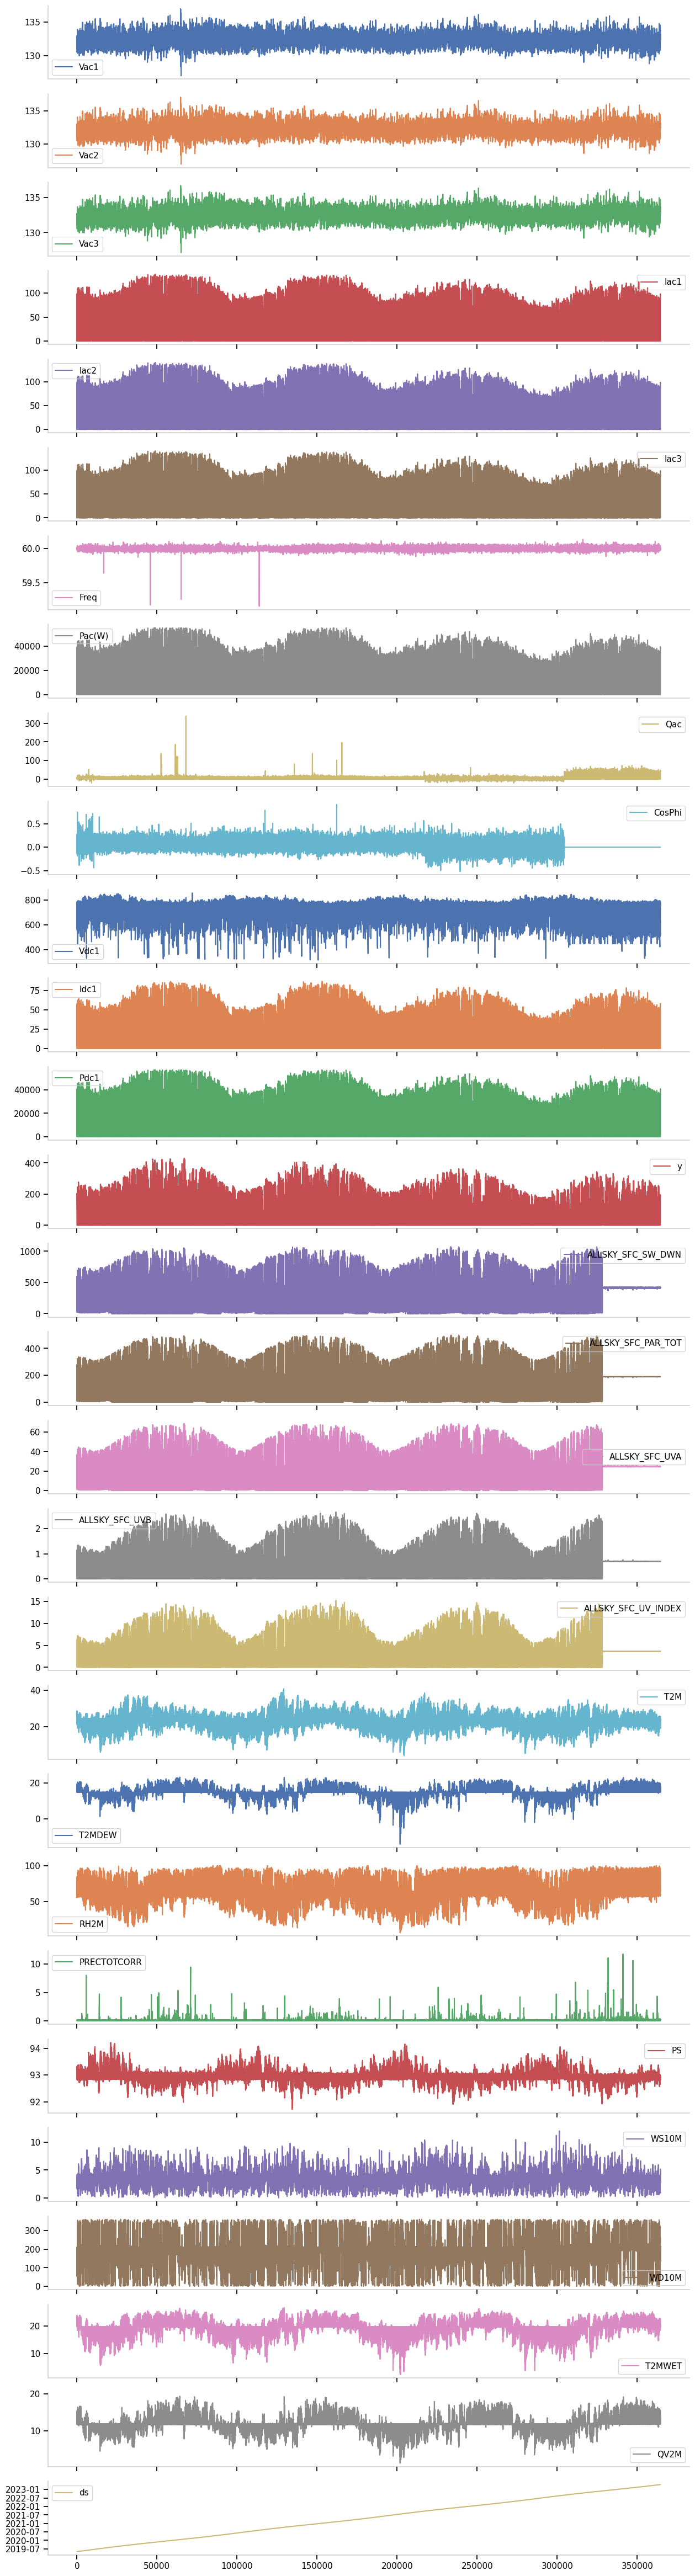

In [ ]:
subset_E.plot(subplots=True, figsize=(15, 60))

In [ ]:
subset_E = subset_E.set_index('ds')
subset_E = subset_E.resample('D').mean()
subset_E = subset_E.fillna(method='ffill')
subset_E = subset_E.reset_index()

<ipython-input-15-7ee48d526e23>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset_E = subset_E.fillna(method='ffill')


In [ ]:
subset_E = subset_E[['Vac1', 'Vac2', 'Vac3', 'Iac1', 'Iac2', 'Iac3', 'Freq', 'Pac(W)', 'Qac',
                     'CosPhi', 'Vdc1', 'Idc1', 'Pdc1', 'ALLSKY_SFC_SW_DWN',
                     'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB',
                     'ALLSKY_SFC_UV_INDEX', 'T2M', 'T2MDEW', 'RH2M', 'PRECTOTCORR', 'PS',
                     'WS10M', 'WD10M', 'T2MWET', 'QV2M', 'ds', 'y']]

In [ ]:
subset_E.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Vac1                 1443 non-null   float64       
 1   Vac2                 1443 non-null   float64       
 2   Vac3                 1443 non-null   float64       
 3   Iac1                 1443 non-null   float64       
 4   Iac2                 1443 non-null   float64       
 5   Iac3                 1443 non-null   float64       
 6   Freq                 1443 non-null   float64       
 7   Pac(W)               1443 non-null   float64       
 8   Qac                  1443 non-null   float64       
 9   CosPhi               1443 non-null   float64       
 10  Vdc1                 1443 non-null   float64       
 11  Idc1                 1443 non-null   float64       
 12  Pdc1                 1443 non-null   float64       
 13  ALLSKY_SFC_SW_DWN    1443 non-nul

In [ ]:
colunas = subset_E.columns

In [ ]:
df_train = subset_E[:-430]
train = df_train[:-300]
val = df_train[-300:]
test = subset_E[-430:]

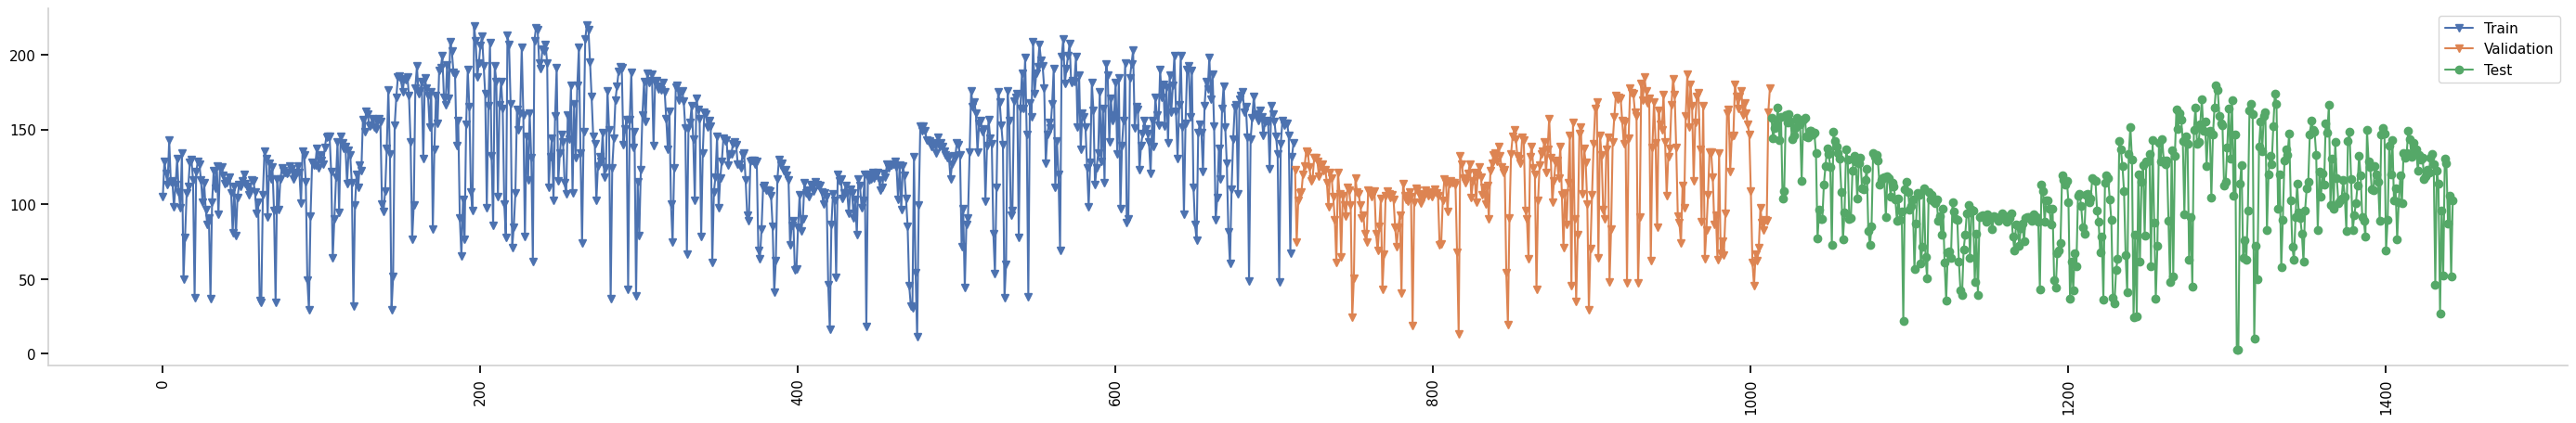

In [ ]:
plt.figure(figsize=(35, 5))
plt.plot(train['y'], marker='v', label='Train')
plt.plot(val['y'], marker='v', label='Validation')
plt.plot(test['y'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
train.drop(columns=['y', 'ds']).shape, val.drop(
    columns=['y', 'ds']).shape, test.drop(columns=['y', 'ds']).shape

((713, 27), (300, 27), (430, 27))

In [ ]:
x_train = train.drop(columns=['y', 'ds']).values.reshape(train.drop(
    columns=['y', 'ds']).shape[0], train.drop(columns=['y', 'ds']).shape[1], 1)
x_val = val.drop(columns=['y', 'ds']).values.reshape(val.drop(
    columns=['y', 'ds']).shape[0], val.drop(columns=['y', 'ds']).shape[1], 1)
x_test = test.drop(columns=['y', 'ds']).values.reshape(test.drop(
    columns=['y', 'ds']).shape[0], test.drop(columns=['y', 'ds']).shape[1], 1)
x_train.shape, x_val.shape, x_test.shape

((713, 27, 1), (300, 27, 1), (430, 27, 1))

In [ ]:
y_train = train['y'].values
y_val = val['y'].values
y_test = test['y'].values
y_train.shape, y_val.shape, y_test.shape

((713,), (300,), (430,))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0,
                mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


input_shape = (27, 1)
mlp_units = [128]

In [ ]:
def tuned(hp):

    clear_session()
    K.clear_session()
    gc.collect()

    model = build_model(

        input_shape,
        hp.Choice('head_size', values=[
                  5, 10, 15, 20, 25, 50, 100, 125, 250, 256]),
        hp.Choice('num_heads', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        hp.Choice('ff_dim', values=[1, 2, 4, 5, 8, 10, 12, 15]),
        hp.Choice('num_transformer_blocks', values=[
                  1, 2, 4, 5, 8, 10, 12, 15]),
        mlp_units,
        hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5]),
        hp.Choice('mlp_dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5]))
    # Compilando o modelo
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-2, 1e-4]),
                                        hp.Choice('epsilon', values=[
                                                  1e-12, 1e-11, 1e-13]),
                                        amsgrad=True),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()],
        # jit_compile = True
    )

    clear_session()
    K.clear_session()
    gc.collect()

    return model


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=30,
    restore_best_weights=True,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_model2a.h5",
    monitor='val_loss',
    save_best_only=True,
)

callbacks = [early_stopping, model_checkpoint]

tuner1 = keras_tuner.RandomSearch(
    tuned,
    objective='val_loss',
    max_trials=2000,
    seed=SEED,
    directory='transformer/output2',
    project_name='transformer')

gc.collect()

tuner1.search(train_dataset, epochs=400, validation_data=val_dataset,
              callbacks=[early_stopping], shuffle=False)

Reloading Tuner from transformer/output2/transformer/tuner0.json


0

In [ ]:
tuner1.results_summary()

Results summary
Results in transformer/output2/transformer
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1670 summary
Hyperparameters:
head_size: 250
num_heads: 8
ff_dim: 15
num_transformer_blocks: 10
dropout: 0.5
mlp_dropout: 0.1
learning_rate: 0.0001
epsilon: 1e-12
Score: 87.7731704711914

Trial 0839 summary
Hyperparameters:
head_size: 10
num_heads: 9
ff_dim: 4
num_transformer_blocks: 10
dropout: 0.5
mlp_dropout: 0.4
learning_rate: 0.0001
epsilon: 1e-12
Score: 89.25394439697266

Trial 1435 summary
Hyperparameters:
head_size: 100
num_heads: 9
ff_dim: 12
num_transformer_blocks: 2
dropout: 0.5
mlp_dropout: 0.2
learning_rate: 0.0001
epsilon: 1e-13
Score: 90.89988708496094

Trial 0808 summary
Hyperparameters:
head_size: 100
num_heads: 3
ff_dim: 8
num_transformer_blocks: 5
dropout: 0.1
mlp_dropout: 0.3
learning_rate: 0.0001
epsilon: 1e-13
Score: 92.77349090576172

Trial 1084 summary
Hyperparameters:
head_size: 15
num_heads: 5
ff_dim: 12
num_transformer_blocks: 1

In [ ]:
best_ml2 = tuner1.get_best_models()[0]
best_ml2.save('transformer.h5')
best_ml2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 27, 1)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 27, 1)                2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 27, 1)                14001     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

                                                                    ']                            
                                                                                                  
 layer_normalization_6 (Lay  (None, 27, 1)                2         ['tf.__operators__.add_5[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 multi_head_attention_3 (Mu  (None, 27, 1)                14001     ['layer_normalization_6[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_6[0][0]
                                                                    ']                            
                                                                                                  
 dropout_6 (Dropout)         (None, 27, 1)                0         ['multi_head_attention_3[0][0]
          

 tf.__operators__.add_11 (T  (None, 27, 1)                0         ['conv1d_11[0][0]',           
 FOpLambda)                                                          'tf.__operators__.add_10[0][0
                                                                    ]']                           
                                                                                                  
 layer_normalization_12 (La  (None, 27, 1)                2         ['tf.__operators__.add_11[0][0
 yerNormalization)                                                  ]']                           
                                                                                                  
 multi_head_attention_6 (Mu  (None, 27, 1)                14001     ['layer_normalization_12[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_12[0][0]
          

 dropout_17 (Dropout)        (None, 27, 15)               0         ['conv1d_16[0][0]']           
                                                                                                  
 conv1d_17 (Conv1D)          (None, 27, 1)                16        ['dropout_17[0][0]']          
                                                                                                  
 tf.__operators__.add_17 (T  (None, 27, 1)                0         ['conv1d_17[0][0]',           
 FOpLambda)                                                          'tf.__operators__.add_16[0][0
                                                                    ]']                           
                                                                                                  
 layer_normalization_18 (La  (None, 27, 1)                2         ['tf.__operators__.add_17[0][0
 yerNormalization)                                                  ]']                           
          

/home/grnbatera/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test = subset_E[-430:]
train_predictions = best_ml2.predict(test_dataset).flatten()
test = pd.DataFrame(
    data={'prediction_label': train_predictions, 'y': y_test, 'ds': test['ds'].values})
test

14/14 [==============================] - 1s 15ms/step


,prediction_label,y,ds
0,143.625412,158.162963,2022-02-10
1,129.066452,144.130727,2022-02-11
2,143.777145,151.187222,2022-02-12
3,143.268478,153.522778,2022-02-13
4,158.005173,164.778727,2022-02-14
...,...,...,...
425,136.531662,127.325102,2023-04-11
426,90.090233,87.204694,2023-04-12
427,106.465019,105.778571,2023-04-13
428,57.299091,51.688776,2023-04-14


In [ ]:
test = test.set_index('ds')
test.to_csv('cpten_transformer.csv')

<Axes: xlabel='ds'>

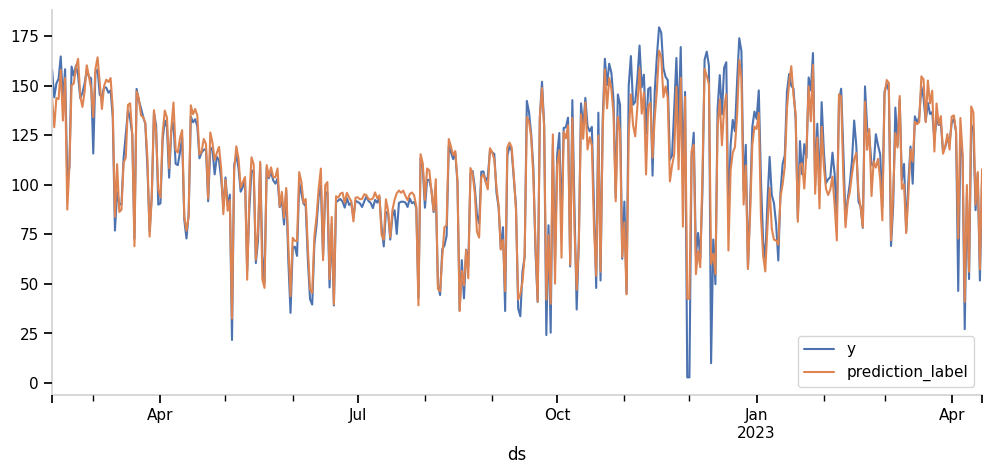

In [ ]:
test[['y', 'prediction_label']].plot(figsize=(12, 5))

In [ ]:
mean_squared_error(test['y'], test['prediction_label'])

75.47016493239181

In [ ]:
mean_squared_error(test['y'], test['prediction_label'], squared=False)

8.687356613630628

In [ ]:
mean_absolute_percentage_error(test['y'], test['prediction_label'])

0.1398913772876972

In [ ]:
r2_score(test['y'], test['prediction_label'])

0.9335863987052432